In [11]:
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp2d
from matplotlib.animation import FuncAnimation, PillowWriter

from nv_files.Field_Generator import omega0_samples,omega0_samples_torch
from nv_files.FEM_Solver import VorticitySolver
from nv_files.Pseudo_Spectral_Solver import VorticitySolver2D
from Base.utilities import clear_hooks
from Base.lla import dgala

import torch
from ml_collections import ConfigDict
from scipy.interpolate import griddata

from nv_files.utilities import deepgala_data_fit,generate_noisy_obs
from nv_files.NavierStokes import NavierStokes
from nv_files.Pseudo_Spectral_Solver import VorticitySolver2D

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [12]:


def nv_experiment():
    config = ConfigDict()
    config.verbose = False

    # Train config
    config.train = False

    # Weights & Biases
    config.wandb = wandb = ConfigDict()
    wandb.project = "Experiment_NV"
    wandb.name = "Vorticity"
    wandb.tag = None

    # General settings
    config.nn_model = "MDNN"  # Options: "NN", "WRF", "MDNN"
    config.lambdas = {"nvs":1, "cond":1, "w0":1, "phi":1}

    # Model-specific settings
    config.model = ConfigDict()
    config.model.input_dim = 3 + 2
    config.model.hidden_dim = 200
    config.model.num_layers = 3 
    config.model.out_dim = 2
    config.model.activation = "tanh"

    # Weight-Random-Factorization
    #config.reparam = ConfigDict({"type":"weight_fact","mean":1.0,"stddev":0.1})

     # Periodic embeddings
    config.model.period_emb = ConfigDict({"period":(1.0, 1.0), "axis":(0, 1) })

    # Fourier embeddings
    config.model.fourier_emb = ConfigDict({"embed_scale":1,"embed_dim":200,"exclude_last_n":2})

    # Navier Stokes Config
    config.nu = 1e-2
    config.time_domain = 2

    # Training settings
    config.seed = 108
    config.learning_rate = 0.001
    config.decay_rate = 0.9
    config.alpha = 0.9  # For updating loss weights
    config.iterations = 5000
    config.start_scheduler = 0.1
    config.weights_update = 250
    config.scheduler_step = 1000 #2000

    config.chunks = 16
    config.points_per_chunk = 50
    config.batch_size = 16*10
    #config.batch_ic = 16*

    # For deep Galerkin- initial conditions
    config.d = 5
    config.tau = np.sqrt(2)
    config.KL_expansion =  1
    config.dim_initial_condition = 128
    config.samples_size_initial = 1000

    # DeepGala
    config.deepgala = False

    # Inverse problem parameters
    config.noise_level = 1e-3
    config.num_observations = 6

    # MCMC configuration
    config.nn_mcmc = False
    config.dgala_mcmc = False

    config.proposal = "random_walk"
    config.uniform_limit = 2
    config.proposal_variance = 5e-1
    config.samples = 1_000_000
    
    # Num Solver Config
    config.fs_n = 128
    config.fs_T = 2
    config.fs_steps = 5e-4

    # Delayed Acceptance
    config.da_mcmc_nn = False
    config.da_mcmc_dgala = False
    config.iter_mcmc = 1_000_000
    config.iter_da = 5_000

    return config

config_experiment = nv_experiment()

nn_path_model = "./models/vorticity_hl3_n300_s20_bs160_kl1.pth"
nn_surrogate_model = torch.load(nn_path_model, map_location=device)
nn_surrogate_model.eval()
nn_surrogate_model.to(device)
nn_surrogate_model.M = nn_surrogate_model.M.to(device)

In [ ]:
data_fit = deepgala_data_fit(config_experiment, device)

llp = dgala(nn_surrogate_model)
llp.fit(data_fit)
llp.optimize_marginal_likelihoodb(error_tolerance=1e-4, max_iter=5000)
#clear_hooks(llp)

#torch.save(llp, dgala_path_model)

Iteration 100, Error: 0.00909, neg_marglik: 1772.32593
Iteration 200, Error: 0.00556, neg_marglik: 1174.29272
Iteration 300, Error: 0.00486, neg_marglik: 896.91016
Iteration 400, Error: 0.00457, neg_marglik: 653.59265
Iteration 500, Error: 0.00418, neg_marglik: 452.32535
Iteration 600, Error: 0.00370, neg_marglik: 297.29050
Iteration 700, Error: 0.00311, neg_marglik: 188.25162
Iteration 800, Error: 0.00241, neg_marglik: 121.13815
Iteration 900, Error: 0.00166, neg_marglik: 87.30453
Iteration 1000, Error: 0.00099, neg_marglik: 74.25885
Iteration 1100, Error: 0.00050, neg_marglik: 70.54321
Iteration 1200, Error: 0.00022, neg_marglik: 69.75073


In [ ]:
from nv_files.nv_mcmc import NVMCMC, NVMCMCDA

obs_points, sol_test, obs_indices,_ = generate_noisy_obs(obs=config_experiment.num_observations,
                                              noise_level=config_experiment.noise_level,
                                              NKL = config_experiment.KL_expansion)
print(config_experiment.noise_level)


def run_mcmc_chain(surrogate_model, obs_points, sol_test, config_experiment,device):
    mcmc = NVMCMC(
        surrogate=surrogate_model,
        observation_locations=obs_points,
        observations_values=sol_test,
        observation_noise=np.sqrt(config_experiment.noise_level),
        nparameters=2*config_experiment.KL_expansion,
        nsamples=config_experiment.samples,
        proposal_type=config_experiment.proposal,
        step_size=config_experiment.proposal_variance,
        uniform_limit = config_experiment.uniform_limit,
        device=device
    )
    return mcmc.run_chain(verbose=True)

0.001


In [22]:
dgala_path_model = "./models/nv_dgala_hl3_n300_s500_bs160_kl1.pth"

llp = torch.load(dgala_path_model, map_location=device)
llp.model.set_last_layer("output_layer")  # Re-register hooks
llp._device = device

#nn_samples = run_mcmc_chain(llp, obs_points, sol_test, config_experiment, device)


In [26]:
llp.gamma

tensor([1.0000, 1.0000, 0.9999, 0.9998, 0.9998, 0.9997, 0.9997, 0.9996, 0.9996,
        0.9995, 0.9994, 0.9994, 0.9992, 0.9989, 0.9987, 0.9986])

In [23]:
torch.linalg.eigvals(llp.posterior_precision)

tensor([6.0469e+08+0.j, 3.7801e+08+0.j, 1.6417e+08+0.j, 1.0152e+08+0.j, 6.4850e+07+0.j,
        6.2261e+07+0.j, 5.8440e+07+0.j, 5.6165e+07+0.j, 3.5820e+07+0.j, 3.1136e+07+0.j,
        2.6483e+07+0.j, 2.3675e+07+0.j, 2.2014e+07+0.j, 2.1227e+07+0.j, 1.9264e+07+0.j,
        1.7987e+07+0.j, 1.7562e+07+0.j, 1.5433e+07+0.j, 1.3556e+07+0.j, 1.2914e+07+0.j,
        1.1734e+07+0.j, 1.1271e+07+0.j, 1.0643e+07+0.j, 1.0496e+07+0.j, 9.3945e+06+0.j,
        8.3740e+06+0.j, 7.9565e+06+0.j, 7.5791e+06+0.j, 7.0509e+06+0.j, 6.7732e+06+0.j,
        6.4409e+06+0.j, 6.3021e+06+0.j, 6.1582e+06+0.j, 6.0219e+06+0.j, 5.7392e+06+0.j,
        5.6503e+06+0.j, 5.5102e+06+0.j, 5.4090e+06+0.j, 5.0784e+06+0.j, 4.8279e+06+0.j,
        4.6955e+06+0.j, 4.5318e+06+0.j, 4.2590e+06+0.j, 4.2180e+06+0.j, 4.0777e+06+0.j,
        3.9586e+06+0.j, 3.8640e+06+0.j, 3.7772e+06+0.j, 3.6548e+06+0.j, 3.5992e+06+0.j,
        3.4398e+06+0.j, 3.3521e+06+0.j, 3.3137e+06+0.j, 3.1883e+06+0.j, 3.0837e+06+0.j,
        3.0456e+06+0.j, 3.0017e+

In [30]:
from Base.utilities import clear_hooks

clear_hooks(llp)
torch.save(llp, f"./models/nvs_lla2.pth")

In [10]:
eingen = torch.real(torch.linalg.eig(llp.H)[0])
eingen[eingen<0]

tensor([])

In [11]:
eingen

tensor([1.4905e+05, 8.2858e+04, 6.5130e+04, 6.0340e+04, 5.5484e+04, 5.1745e+04,
        4.8991e+04, 4.5703e+04, 4.4849e+04, 4.0639e+04, 4.0339e+04, 3.6916e+04,
        3.5955e+04, 3.4974e+04, 3.3474e+04, 3.1470e+04, 3.0908e+04, 3.0265e+04,
        2.9257e+04, 2.8371e+04, 2.7358e+04, 2.6528e+04, 2.5497e+04, 2.4854e+04,
        2.3260e+04, 2.2991e+04, 2.2019e+04, 2.1225e+04, 2.0670e+04, 1.9320e+04,
        1.9273e+04, 1.8255e+04, 1.7719e+04, 1.7019e+04, 1.6283e+04, 1.5508e+04,
        1.4701e+04, 1.4460e+04, 1.4085e+04, 1.3717e+04, 1.3226e+04, 1.3123e+04,
        1.2337e+04, 1.2242e+04, 1.1900e+04, 1.1518e+04, 1.1026e+04, 1.0835e+04,
        1.0532e+04, 1.0276e+04, 9.8826e+03, 9.6609e+03, 9.7300e+03, 9.0955e+03,
        8.9225e+03, 8.6840e+03, 8.3849e+03, 8.3224e+03, 8.1107e+03, 7.9013e+03,
        7.7286e+03, 7.5460e+03, 7.3816e+03, 7.2213e+03, 6.9742e+03, 6.9114e+03,
        6.6801e+03, 6.6193e+03, 6.5485e+03, 6.4097e+03, 6.3517e+03, 6.0837e+03,
        5.9067e+03, 5.7943e+03, 5.7088e+

Text(0.5, 1.0, 'Marg.Lik: Prior Prec.')

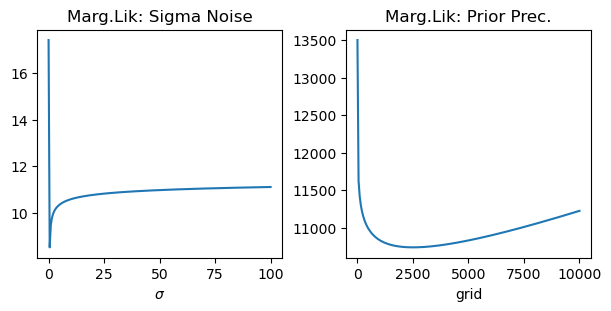

In [31]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')

llp = torch.load(f"./models/nvs_lla2.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

sn = torch.linspace(0.0001,100, 200)  # Spatial grid in X direction
log_marg_lh = []
for sn_val in sn:
    llp.sigma_noise = sn_val
    log_marg_lh.append(-llp.log_marginal_likelihood())
axs[0].plot(sn,np.log(log_marg_lh))
axs[0].set_xlabel("$\sigma$")
axs[0].set_title("Marg.Lik: Sigma Noise")

llp = torch.load(f"./models/nvs_lla2.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

priorpre = torch.linspace(0.1,10000, 200)  # Spatial grid in X direction
log_marg_pp = []
for pp in priorpre:
    llp.prior_precision = [pp]
    log_marg_pp.append(-llp.log_marginal_likelihood())

axs[1].plot(priorpre,log_marg_pp)
axs[1].set_xlabel("grid")
axs[1].set_title("Marg.Lik: Prior Prec.")

In [29]:
llp = torch.load(f"./models/nvs_lla.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks
llp.prior_precision = 1.
# print(llp._H_factor, torch.linalg.norm(llp.H,ord=2),torch.linalg.norm(llp.prior_precision_diag,ord=2))
# print(torch.linalg.norm(llp.posterior_precision))
llp.optimize_marginal_likelihoodb(error_tolerance=1e-3, max_iter=5000)
print(llp.sigma_noise,llp.prior_precision)
# print(llp._H_factor, torch.linalg.norm(llp.H,ord=2),torch.linalg.norm(llp.prior_precision_diag,ord=2))
# print(torch.linalg.norm(llp.posterior_precision))

Iteration 100, Error: 0.01001, neg_marglik: 1229.59546
Iteration 200, Error: 0.01000, neg_marglik: -10441.39062
Iteration 300, Error: 0.00991, neg_marglik: -21935.70117
Iteration 400, Error: 0.00934, neg_marglik: -32229.28320
Iteration 500, Error: 0.00698, neg_marglik: -37602.02734
Iteration 600, Error: 0.00467, neg_marglik: -38283.35938
Iteration 700, Error: 0.00369, neg_marglik: -38477.81641
Iteration 800, Error: 0.00234, neg_marglik: -38577.64062
Iteration 900, Error: 0.00100, neg_marglik: -38604.68750
tensor(0.0080) tensor([2143.2124])


In [17]:
X = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y

data_test = torch.hstack((X.reshape(-1,1),Y.reshape(-1,1),2*torch.ones_like(X.reshape(-1,1)))).float()

#th1 = theta[:,:,100].reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)
th1 = torch.tensor((-1000,1000)).reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)
#llp.sigma_noise = 0.021
dataset1 = torch.cat((data_test, th1), dim=1)  # Shape (16000, 103)

surg_mu, surg_sigma = llp(dataset1)

surg_mu = surg_mu[:,0].view(-1, 1).detach().numpy()

surg_sigma = surg_sigma[:, 0].view(-1, 1).detach().numpy()

pred_mu = griddata((X.reshape(-1), Y.reshape(-1)), surg_mu.flatten(),(X, Y), method='cubic')
pred_sigma = griddata((X.reshape(-1), Y.reshape(-1)), surg_sigma.flatten(),(X, Y), method='cubic')


fig, axs = plt.subplots(1,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)

pcm1 = axs[0].pcolormesh(X, Y, pred_mu, cmap='jet')
axs[0].set_title("NN Prediction")
plt.colorbar(pcm1)

pcm = axs[1].pcolormesh(X, Y, pred_sigma, cmap='jet')
axs[1].set_title("NN Uncertainty")
plt.colorbar(pcm)

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 322 is not positive-definite).